In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import math
from scipy.optimize import curve_fit, differential_evolution

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df=pd.read_excel("/content/drive/MyDrive/Cursos/MAFI/Renta Fija/tasas.xlsx")
df.head()

,Periodo,"1.Bonos en UF a 1 año (BCU, BTU)","2.Bonos en UF a 2 años (BCU, BTU)","3.Bonos en UF a 5 años (BCU, BTU)","4.Bonos en UF a 10 años (BCU, BTU)","5.Bonos en UF a 20 años (BCU, BTU)","6.Bonos en UF a 30 años (BCU, BTU)"
0,2016-01-01,0.847874,0.926377,1.232872,1.553460,1.828612,1.956905
1,2016-02-01,0.674523,0.814961,1.092502,1.395829,1.672611,1.810419
2,2016-03-01,0.822281,0.861093,1.124635,1.398061,1.635483,1.709110
3,2016-04-01,0.961200,0.963380,1.125539,1.391613,1.639808,1.677249
4,2016-05-01,0.879164,0.912128,1.182680,1.487671,1.727312,1.806570


In [ ]:
for i in range(len(df)):
  for j in range(len(df.columns)):
    if pd.isna(df.iloc[i, j]):
      df.iloc[i, j] = df.iloc[:,j].mean()

In [ ]:
!pip install nelson_siegel_svensson
from nelson_siegel_svensson.calibrate import calibrate_ns_ols

y = np.array(df.sort_values('Periodo').iloc[len(df)-4, 1:len(df.columns)], dtype='float')
t = np.array([1, 2, 5, 10, 20, 30], dtype='float')
curva, status = calibrate_ns_ols(t, y, tau0=1.0)
assert status.success
print(curva)

NelsonSiegelCurve(beta0=2.0580737956091837, beta1=-4.488619936406801, beta2=-6.824033463515559, tau=1.6640819805614955)


# Nelson & Siegel

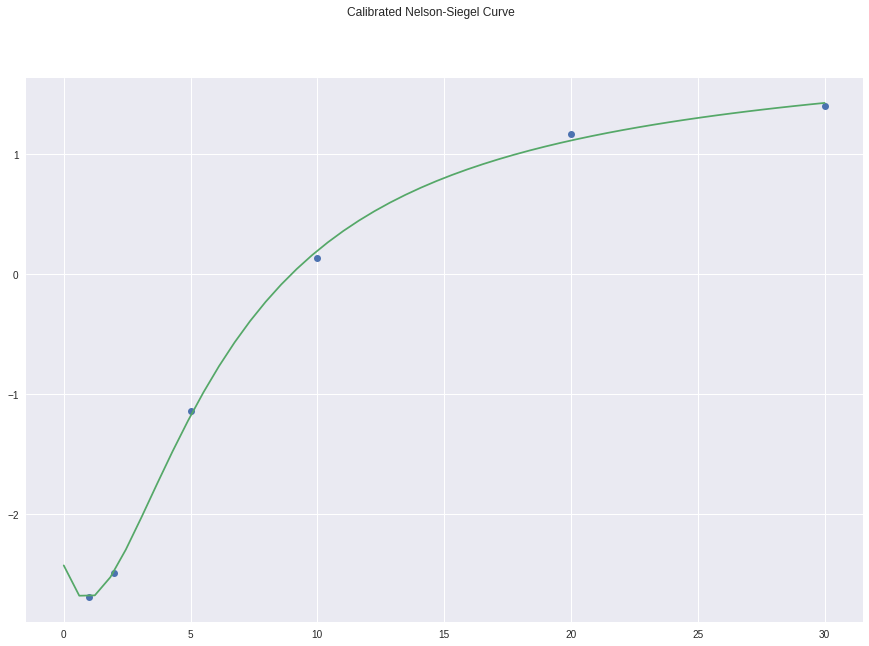

In [ ]:
plt.style.use(['seaborn'])
with plt.style.context('seaborn'):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
  fig.suptitle('Calibrated Nelson-Siegel Curve')
  ax.plot(t, y, 'o');
  t2 = np.linspace(0, 30)
  ax.plot(t2, curva(t2), '-');

# Nelson-Siegel-Svensson NLS

In [ ]:
from scipy.optimize import curve_fit
c = len(df.columns)
X = np.array([1,2,5,10,20,30])
y = np.array(df.iloc[62,1:])

def nss(x, b0, b1, b2, b3, t1, t2):
  return b0 + b1*(1-np.exp(-x/t1))*(-x/t1)**(-1) + b2*((1-np.exp(-x/t1))*(-x/t1)**(-1)-np.exp(-x/t1)) + b3*((1-np.exp(-x/t2))*(-x/t2)**(-1)-np.exp(-x/t2))

b, cov = curve_fit(f=nss, xdata=X, ydata=y, bounds=(-np.inf, np.inf))

b

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


array([ -0.69779233, -18.82759371,   2.57130697,   8.1590735 ,
        12.17722777,  12.17639816])

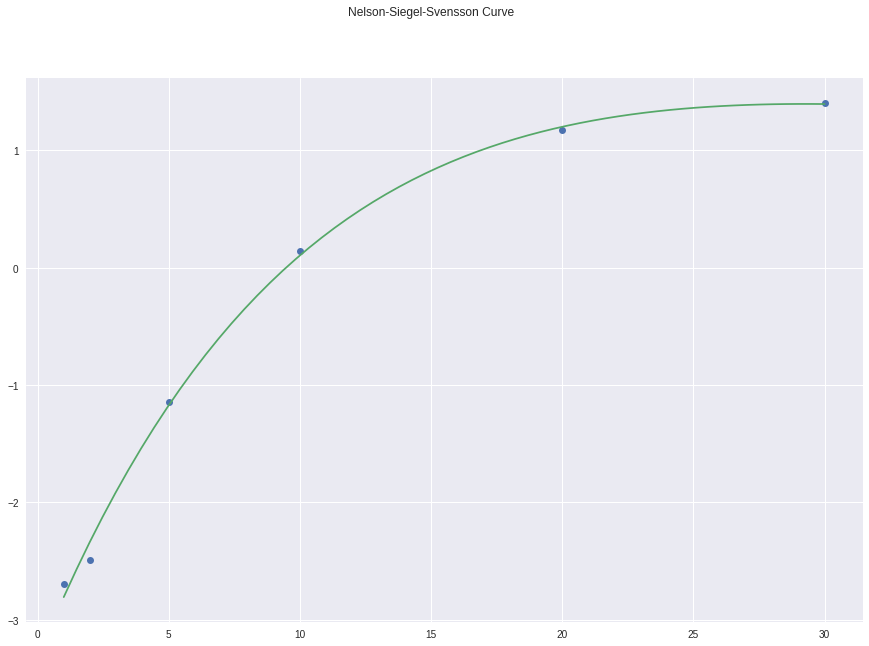

In [ ]:
xModel = np.linspace(min(X), max(X), 60)
plt.style.use(['seaborn'])
with plt.style.context('seaborn'):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
  fig.suptitle('Nelson-Siegel-Svensson Curve')
  ax.plot(X, y, 'o');
  ax.plot(xModel, nss(xModel, *b), '-');

# Análisis de Componentes Principales

In [ ]:
df_normalized = (df.drop(columns=['Periodo'])-df.drop(columns=['Periodo']).mean())/df.drop(columns=['Periodo']).std()
df_normalized.fillna(df_normalized.mean(), inplace=True)
df_normalized.head()

,"1.Bonos en UF a 1 año (BCU, BTU)","2.Bonos en UF a 2 años (BCU, BTU)","3.Bonos en UF a 5 años (BCU, BTU)","4.Bonos en UF a 10 años (BCU, BTU)","5.Bonos en UF a 20 años (BCU, BTU)","6.Bonos en UF a 30 años (BCU, BTU)"
0,0.752055,0.792016,0.853831,0.797007,0.627353,0.596184
1,0.596517,0.694796,0.680882,0.571630,0.367017,0.354688
2,0.729092,0.735051,0.720473,0.574822,0.305058,0.187672
3,0.853737,0.824304,0.721587,0.565602,0.312276,0.135146
4,0.780130,0.779583,0.791990,0.702943,0.458302,0.348344


In [ ]:
varcov_matrix=np.array(np.cov(df_normalized, rowvar=False))
varcov_matrix

array([[1.        , 0.93448169, 0.94534346, 0.89039444, 0.76273364,
        0.73038124],
       [0.93448169, 1.        , 0.97540258, 0.8991461 , 0.76149427,
        0.72452443],
       [0.94534346, 0.97540258, 1.        , 0.96178098, 0.85696957,
        0.82621476],
       [0.89039444, 0.8991461 , 0.96178098, 1.        , 0.96074523,
        0.94329891],
       [0.76273364, 0.76149427, 0.85696957, 0.96074523, 1.        ,
        0.99606436],
       [0.73038124, 0.72452443, 0.82621476, 0.94329891, 0.99606436,
        1.        ]])

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(varcov_matrix)
df_eigen = pd.DataFrame({"Eigenvalues":eigenvalues}, index=range(1, len(eigenvalues)+1))
df_eigen.head()

,Eigenvalues
1,5.394556
2,0.516500
3,0.072064
4,0.011542
5,0.003172


In [ ]:
df_eigen["explained"] = df_eigen["Eigenvalues"] / np.sum(df_eigen["Eigenvalues"])
df_eigen.style.format({"explained": "{:.1%}"})

,Eigenvalues,explained
1,5.394556,89.9%
2,0.516500,8.6%
3,0.072064,1.2%
4,0.011542,0.2%
5,0.003172,0.1%
6,0.002166,0.0%


In [ ]:
pc = df_normalized.dot(eigenvectors)
pc

,0,1,2,3,4,5
0,1.807522,0.178226,0.045551,-0.069598,-0.013540,0.011423
1,1.336551,0.306938,0.079213,-0.043222,-0.007823,0.025662
2,1.332563,0.513489,0.017528,-0.082601,-0.049033,-0.027009
3,1.396715,0.635061,-0.030992,-0.025791,-0.066978,-0.067021
4,1.581161,0.397275,0.013885,-0.084432,-0.057949,-0.023232
...,...,...,...,...,...,...
61,-4.853118,-1.530189,0.085523,0.296187,0.007011,-0.013866
62,-3.557131,-2.027196,0.173752,0.094001,-0.114284,0.013042
63,-1.788417,-0.821155,-1.359638,-0.099589,-0.143639,-0.006540
64,-0.821590,-0.825422,-0.877693,-0.133431,0.084956,-0.029023


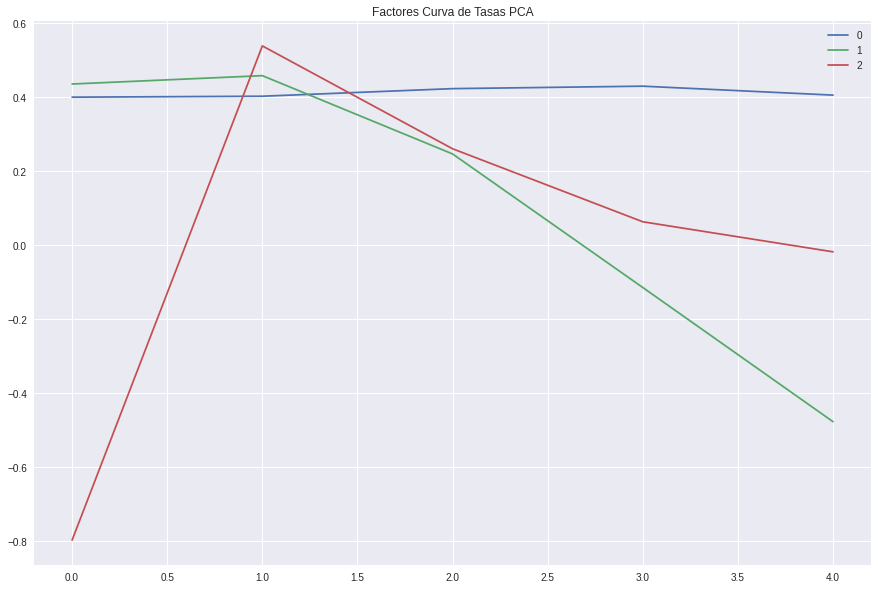

In [ ]:
pd.DataFrame(eigenvectors).iloc[:,0:3].head().plot(figsize = (15, 10), title = "Factores Curva de Tasas PCA");

In [ ]:
pc.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']

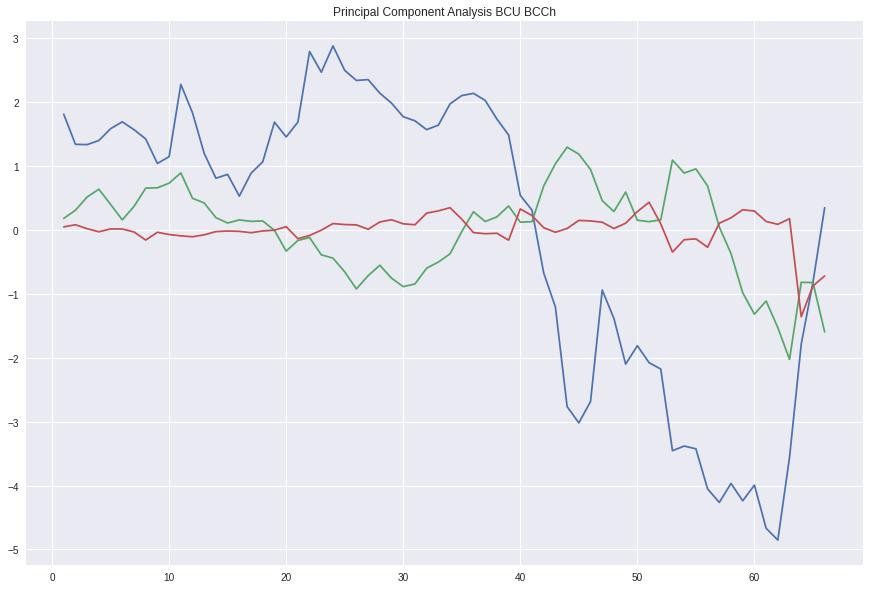

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(range(1, len(pc)+1), pc[['PC1', 'PC2', 'PC3']])
plt.title('Principal Component Analysis BCU BCCh');

loading coeficiente de la regresión: Eigenvector cuanto le pega cada factor a las series de datos

# Nelson y siegel Dinámico - Diebold & Li

In [ ]:
tau = np.array([1, 2, 5, 10, 20, 30])
X = np.zeros(shape=(len(tau), 3))

In [ ]:
for i in range(len(X)):
  lmbt = 0.0609*tau[i]
  X[i,:] = np.array([1, (1-np.exp(-lmbt))/(lmbt), (1-np.exp(-lmbt))/(lmbt)-np.exp(-lmbt)])

X

array([[1.        , 0.97015884, 0.02924151],
       [1.        , 0.94149905, 0.05617363],
       [1.        , 0.86209515, 0.12460312],
       [1.        , 0.74894172, 0.20504723],
       [1.        , 0.5781435 , 0.28232228],
       [1.        , 0.45927995, 0.29838442]])

In [ ]:
from sklearn.linear_model import LinearRegression
beta = np.zeros(shape=(len(df), 3))
for i in range(len(df)):
  y = np.array(df.iloc[i, 1:])
  x = X
  model = LinearRegression(fit_intercept = False).fit(x, y)
  beta[i,:] = model.coef_

In [ ]:
level = beta[:, 0]
slope = beta[:, 1]
curv = beta[:, 2]

In [ ]:
var_lat = pd.DataFrame({'Nivel': level, 'Pendiente': slope, 'Curvatura': curv})
var_lat.head()

,Nivel,Pendiente,Curvatura
0,0.955950,-0.226722,3.659752
1,0.840721,-0.252664,3.583850
2,0.748356,-0.043268,3.271667
3,1.217309,-0.373201,2.165934
4,0.792619,-0.042295,3.447259


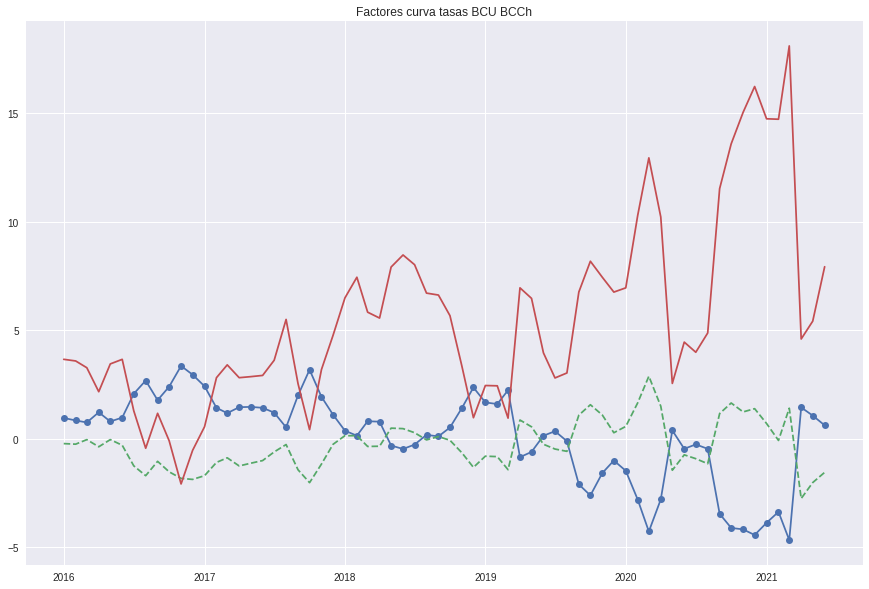

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(df.iloc[:,0], level, '-o', label = 'Nivel')
plt.plot(df.iloc[:,0], slope, '--', label = 'Pendiente')
plt.plot(df.iloc[:,0], curv, '-x', label = 'Curvatura')
plt.title('Factores curva tasas BCU BCCh');

In [ ]:
from statsmodels.tsa.api import VAR

In [ ]:
model = VAR(var_lat)
model.select_order(4).summary()

,AIC,BIC,FPE,HQIC
0,1.197,1.300,3.311,1.238
1,-3.983,-3.571*,0.01864,-3.821*
2,-4.036*,-3.315,0.01772*,-3.753
3,-3.890,-2.861,0.02062,-3.486
4,-3.846,-2.508,0.02178,-3.320


In [ ]:
fitted = model.fit(2)

In [ ]:
fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 29, Jul, 2021
Time:                     15:03:10
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -3.41486
Nobs:                     64.0000    HQIC:                  -3.84417
Log likelihood:          -119.492    FPE:                  0.0162347
AIC:                     -4.12324    Det(Omega_mle):       0.0118907
--------------------------------------------------------------------
Results for equation Nivel
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.774438         0.617697           -1.254           0.210
L1.Nivel             2.906411         0.860359            3.378           0.001
L1.Pendiente         2.047077         0.686196            2.983 

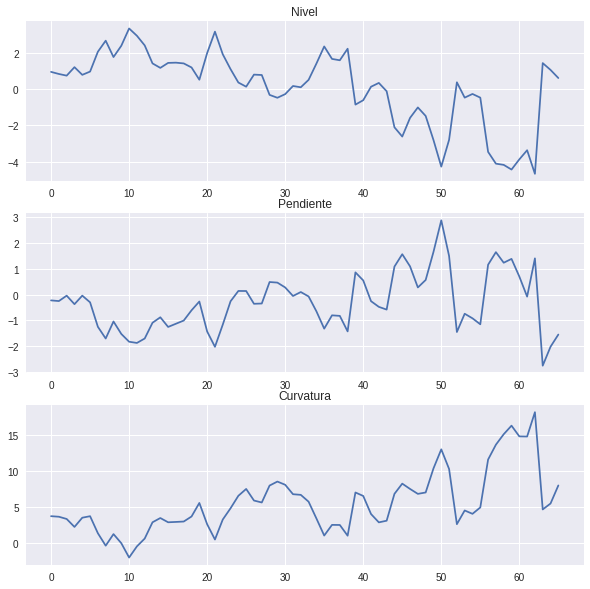

In [ ]:
fitted.plot();

In [ ]:
y = fitted.fittedvalues

In [ ]:
dli=pd.DataFrame(np.array(y).dot(np.transpose(X)), index = df['Periodo'][2:], columns=df.columns[1:])

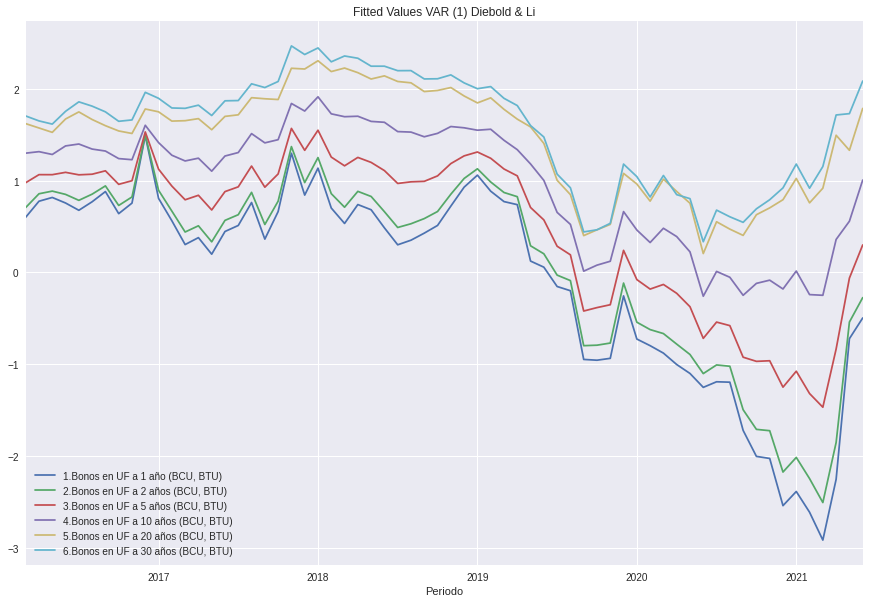

In [ ]:
dli.plot(figsize = (15,10), title = 'Fitted Values VAR (1) Diebold & Li');

In [ ]:
Xi = np.zeros(shape=(30, 3))
for i in range(1, len(Xi)+1):
  lmbt = 0.0609*i
  Xi[i-1,:] = np.array([1, (1-np.exp(-lmbt))/(lmbt), (1-np.exp(-lmbt))/(lmbt)-np.exp(-lmbt)])

Xi.shape

(30, 3)

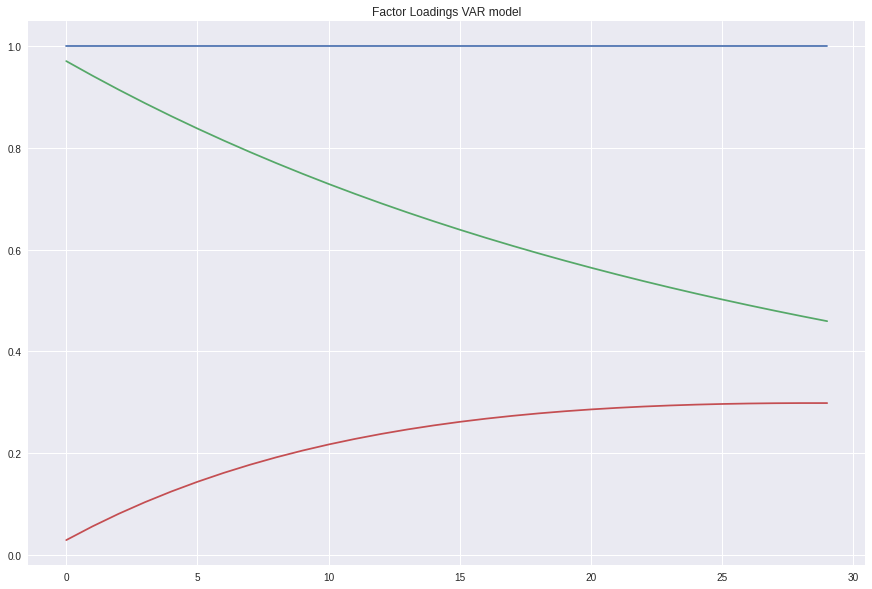

In [ ]:
plt.figure(figsize = (15,10))
plt.plot(range(30), Xi)
plt.title('Factor Loadings VAR model');

In [ ]:
dli=pd.DataFrame(np.array(y).dot(np.transpose(Xi)), index = df['Periodo'][2:], columns=[str(x)+'Y' for x in range(1, 31)])

In [ ]:
dli.iloc[coord[0], :].shape

(30,)

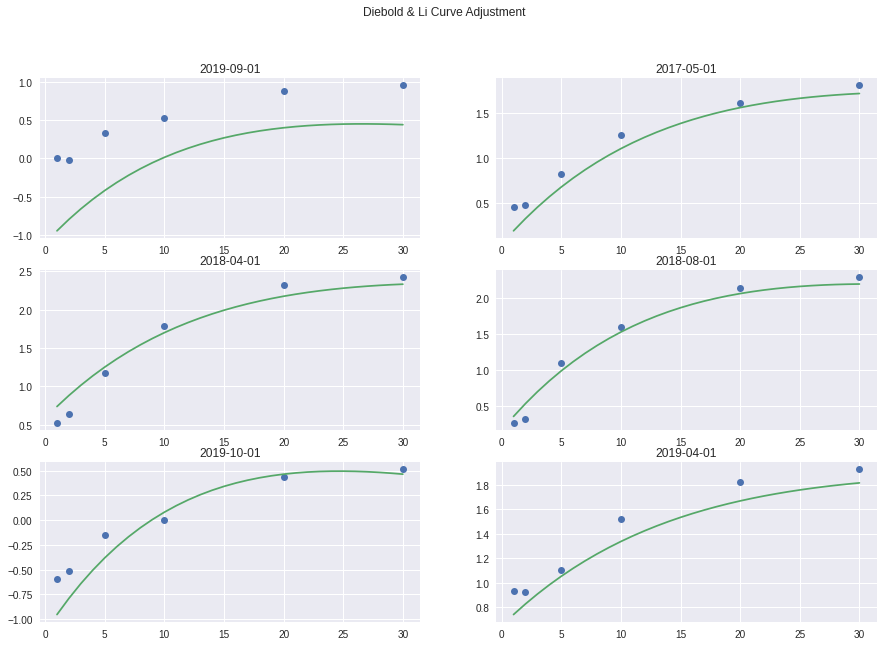

In [ ]:
from random import sample

coord = sample(range(len(dli)), 6)

tau_i = np.linspace(1, 30, 30)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
fig.suptitle('Diebold & Li Curve Adjustment')
ax[0,0].plot(tau, df.iloc[coord[0], 1:], 'o');
ax[0,0].plot(tau_i, dli.iloc[coord[0], :], '-');
ax[0,0].set_title(f'{dli.index[coord[0]].date()}');
ax[1,0].plot(tau, df.iloc[coord[1], 1:], 'o');
ax[1,0].plot(tau_i, dli.iloc[coord[1], :], '-');
ax[1,0].set_title(f'{dli.index[coord[1]].date()}');
ax[0,1].plot(tau, df.iloc[coord[2], 1:], 'o');
ax[0,1].plot(tau_i, dli.iloc[coord[2], :], '-');
ax[0,1].set_title(f'{dli.index[coord[2]].date()}');
ax[1,1].plot(tau, df.iloc[coord[3], 1:], 'o');
ax[1,1].plot(tau_i, dli.iloc[coord[3], :], '-');
ax[1,1].set_title(f'{dli.index[coord[3]].date()}');
ax[2,1].plot(tau, df.iloc[coord[4], 1:], 'o');
ax[2,1].plot(tau_i, dli.iloc[coord[4], :], '-');
ax[2,1].set_title(f'{dli.index[coord[4]].date()}');
ax[2,0].plot(tau, df.iloc[coord[5], 1:], 'o');
ax[2,0].plot(tau_i, dli.iloc[coord[5], :], '-');
ax[2,0].set_title(f'{dli.index[coord[5]].date()}');

# Vasicek Model

In [ ]:
def vasicek(r0, g, rb, s, t=1., n=10):
  # np.random.seed(seed)
  dt = t/float(n)
  rates = [r0]
  for i in range(n):
      dr = g*(rb-rates[-1])*dt + s*np.random.normal()
      rates.append(rates[-1] + dr)
  return range(n+1), rates

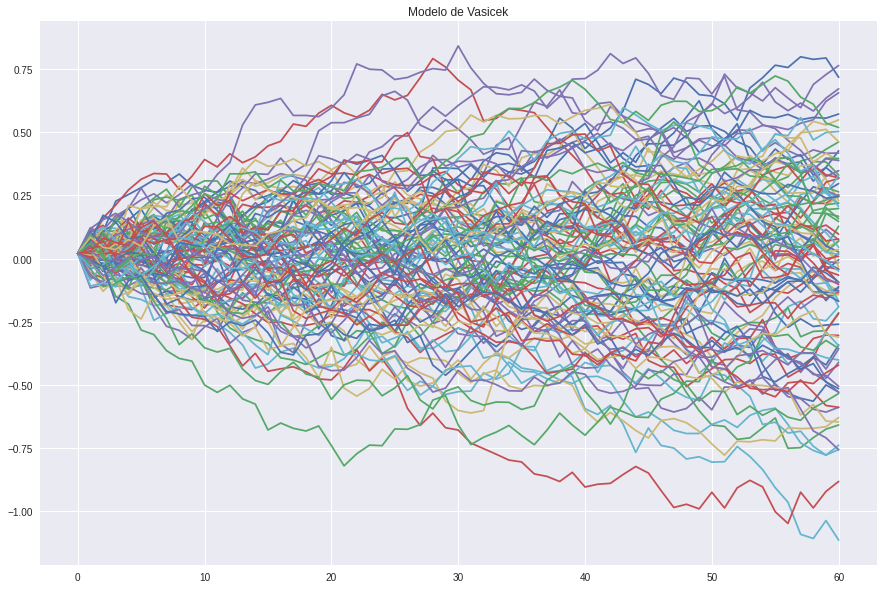

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Modelo de Vasicek')
theta = 0.05
t0 = 0.02
for i in range(100):
  x, y = vasicek(t0, 0.2, theta, 0.05, t = .5, n = 60)
  plt.plot(x, y, '-')

# Black, Derman & Toy

In [ ]:
from scipy.optimize import fsolve
import math
import copy

A continuación se presenta una función para presentar un output ordenado del 

1.   List item
2.   List item

árbol binomial

In [ ]:
def print_lattice(lattice, info = []):
  print("")
  levels = len(lattice[-1])
  start_date = len(lattice[0])-1
  dates = levels - start_date
  outlist = []
  col_widths = [0]*dates
  for j in range(levels):
    level = []
    for k in range(dates):
      try:
        point = "{:.16f}".format(lattice[k][levels-1-j])
        esc_width = 0
        if info != [] and info[k][levels-1-j] > 0:
          point = (point, 'red')
          esc_width += 9
        level.append(point)
        col_widths[k] = max(col_widths[k], len(point) - esc_width)
      except IndexError:
        level.append('')
    outlist.append(level)
  separator = "|".join(['-' * w for w in col_widths])
  formats = [ ]
  for k in range(dates):
    formats.append("%%%ds" % col_widths[k])
  pattern = " ".join(formats)
  print(pattern % tuple(str(start_date + time) for time in range(dates)))
  print(separator)
  for line in outlist:
    print(pattern % tuple(line))

In [ ]:
def factor(time):
  factor = [[]]
  temp = []
  for x in range(time):
    if x == 0:
      factor[0].append(0)
    else:
      for y in range(0, x+1):
        if y == 0:
          temp.append(1)
        else:
          temp.append(y*2)
          x = x-2
      factor.append(temp)
      temp = []
  return factor

Árbol para el año 2 no automatizado

In [ ]:
m = 0.03

# precios bonos zero cupón con curva hipotética

a1 = 100/(1+.1)**1
a2 = 100/(1+.11)**2
a3 = 100/(1+.12)**3
a4 = 100/(1+.125)**4
a5 = 100/(1+.13)**5

r = [.1, .11, .12, .125, .13]

def bdtTwo(guess):
  ru = guess * math.exp(2 * 0.19) # volatilidad de tasas zero hipotéticas al año 2
  rd = guess
  N1 = 100/(1+ru)
  N2 = 100/(1+rd)
  return (0.5*((N1/(1+r[0])) + (N2/(1+r[0])))-a2)
g = fsolve(bdtTwo, m)[0]

In [ ]:
vol = [.2, .19, .18, .16, .14]
ru = g*math.exp(2*vol[1])
rd = g

rateUptoYearTwo = [[r[0]], [ru, rd]]

rateUptoYearTwo = [list(reversed(x)) for x in rateUptoYearTwo]

print_lattice(rateUptoYearTwo, info=[])


                 0                  1
------------------|------------------
                   0.1431804665295065
0.1000000000000000 0.0979155956125509


Las tasas estimadas en la celda anterior, deben cumplir con la siguiente fórmula:

$0.5 * ln(\frac{r_{u}}{r_{d}}) = \sigma \sqrt{\delta*t}$

(Siguiendo Hull 2010)

In [ ]:
abs((0.5*math.log(ru/rd))-(vol[1]*math.sqrt(1))) < 0.0001

True

In [ ]:
def bdtThree(guess):
  ruu = guess[0] * math.exp(4 * guess[1])
  rud = guess[0] * math.exp(2 * guess[1])
  rdd = guess[0]

  N1 = (100)/(1+ruu)
  N2 = (100)/(1+rud)
  N3 = (100)/(1+rdd)

  ans1 = (0.5*N1 + 0.5*N2)/(1+ru)
  ans2 = (0.5*N3 + 0.5*N2)/(1+rd)

  yu = math.sqrt(100/ans1) - 1
  yd = math.sqrt(100/ans2) - 1

  out = [((0.5*ans1 + 0.5*ans2)/(1+r[0]) - a3)]
  out.append((0.5 * math.log(yu/yd) - 0.18))

  return out

In [ ]:
guess = [0.1, 0.1]

In [ ]:
k = fsolve(bdtThree, guess)

ruu = k[0] * math.exp(4*k[1])
rud = k[0] * math.exp(2*k[1])
rdd = k[0]

In [ ]:
rateUpToYearThree = [[r[0]], [ru, rd], [ruu, rud, rdd]]
rateUpToYearThree = [list(reversed(x)) for x in rateUpToYearThree]

In [ ]:
print_lattice(rateUpToYearThree, info = [])


                 0                  1                  2
------------------|------------------|------------------
                                      0.1941872111538783
                   0.1431804665295065 0.1376686893497773
0.1000000000000000 0.0979155956125509 0.0975999805273837


In [ ]:
multiplier = factor(30)
nNodes = 30
m_guess = 0.2

In [ ]:
ObservedRate = dli.iloc[len(dli)-1, :]
ObservedRate

1Y    -0.495475
2Y    -0.274030
3Y    -0.068408
4Y     0.122406
5Y     0.299365
6Y     0.463364
7Y     0.615239
8Y     0.755778
9Y     0.885719
10Y    1.005752
11Y    1.116527
12Y    1.218651
13Y    1.312694
14Y    1.399190
15Y    1.478640
16Y    1.551514
17Y    1.618250
18Y    1.679263
19Y    1.734936
20Y    1.785633
21Y    1.831691
22Y    1.873429
23Y    1.911142
24Y    1.945111
25Y    1.975594
26Y    2.002836
27Y    2.027065
28Y    2.048495
29Y    2.067325
30Y    2.083742
Name: 2021-06-01 00:00:00, dtype: float64

In [ ]:
vol = dli.apply(np.std)
vol

1Y     1.091409
2Y     1.017278
3Y     0.950985
4Y     0.892014
5Y     0.839864
6Y     0.794041
7Y     0.754060
8Y     0.719440
9Y     0.689710
10Y    0.664406
11Y    0.643079
12Y    0.625299
13Y    0.610658
14Y    0.598779
15Y    0.589314
16Y    0.581948
17Y    0.576404
18Y    0.572437
19Y    0.569834
20Y    0.568414
21Y    0.568023
22Y    0.568531
23Y    0.569830
24Y    0.571830
25Y    0.574455
26Y    0.577644
27Y    0.581345
28Y    0.585514
29Y    0.590116
30Y    0.595117
dtype: float64

In [ ]:
zCB = []
for i in range(len(vol)):
  x = 100/(1+ObservedRate[i])**(i+1)
  zCB.append(x)
zCB

[198.20635484335443,
 189.74145654177295,
 123.68651828677139,
 63.008565701274556,
 26.998736613584256,
 10.183254254550635,
 3.486119328884469,
 1.1072412759292598,
 0.3316706772142448,
 0.09489136083531047,
 0.02619014668894078,
 0.0070296315889662965,
 0.0018469905155504597,
 0.0004776343913707073,
 0.00012212320679178316,
 3.0990868980889057e-05,
 7.830867678805822e-06,
 1.975718857705309e-06,
 4.988888508350858e-07,
 1.263349213841994e-07,
 3.2139345282592765e-08,
 8.226046123362282e-09,
 2.1209993900191732e-09,
 5.515191201516495e-10,
 1.4476294049603407e-10,
 3.8386337727986226e-11,
 1.0289895517677839e-11,
 2.790011381820297e-12,
 7.655367670650413e-13,
 2.126468123739671e-13]

In [ ]:
temp_rate_tracker = [[ObservedRate[0]]]

In [ ]:
def bdtOne(guess):
  ru = guess * np.exp(2*vol[1])
  rd = guess
  N1 = 100/(1+ru)
  N2 = 100/(1+rd)
  return (0.5*((N1/(1+ObservedRate[0])) + (N2/(1+ObservedRate[0]))) - zCB[0])

In [ ]:
g = fsolve(bdtOne, m_guess)[0]
ru = g * np.exp(2*vol[1])
rd = g

print(ru, rd)

-5.459625210900155e-17 -7.13783599631234e-18


In [ ]:
m = [0.1, 0.1]
final_rate_tracker = [[]]
temp_rate_tracker = [[ObservedRate[0]], [ru, rd]]
mo = [[0.1], [rd, 1]]
m = [0.1, 0.1]
final_rate_tracker = temp_rate_tracker[1:]

In [ ]:
def rateCalculator(m, node):
  rate = []
  for x in range(0, node+1):
    if x == node:
      rate.append(m[0])
    else:
      rate.append(m[0]*np.exp(multiplier[node][x] * m[1]))
  return rate

In [ ]:
def valueCalculator(n, node, final_rate_tracker):
  nValue = []
  nValue2 = []
  rate = []
  final_rate_tracker = final_rate_tracker[:]
  final_rate_tracker.reverse()
  for x in range(node+1):
    if x == node:
      rate.append(float(m[0]))
    else:
      rate.append(m[0] * np.exp(multiplier[node][x] * m[1]))
  for x in range(len(rate)):
    nValue2.append(((100)/(1+rate[x])))
    nValue = copy.deepcopy(nValue2)
  nValue2 = []
  y = 0

  while len(nValue) > 2:
    if len(nValue) <= 2:
      break
    
    for x in range(len(nValue)-1):
      nValue2.append((0.5*((nValue[x]) + (nValue[x+1])))/(1+final_rate_tracker[y][x]))
    if y == 0:
      yu = np.sqrt(100/nValue2[0]) - 1
      yd = np.sqrt(100/nValue2[1]) - 1
    rate = []
    y = y+1
    nValue = nValue2[:]
    nValue2 = []
  out = [(0.5*((nValue[0]) + (nValue[1]))/(1+temp_rate_tracker[0][0]) - zCB[node])]
  out.append((0.5 * np.log(yu/yd) - vol[node]))

  return out

In [ ]:
def solutionIterator(mo, nNodes, final_rate_tracker, temp_rate_tracker):

  for x in range(2, nNodes):
    data = (x, final_rate_tracker)
    mo.append(fsolve(valueCalculator, m, args=data))
    temp_rate_tracker.append(rateCalculator(mo[x], x))
    final_rate_tracker = temp_rate_tracker[1:]
    data = (x, final_rate_tracker)
  return temp_rate_tracker

In [ ]:
len(zCB)

30

In [ ]:
final_rate_tracker = solutionIterator(mo, nNodes, final_rate_tracker, temp_rate_tracker)[:]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [ ]:
reversed_list = [list(reversed(x)) for x in final_rate_tracker]

finalLattice = [[100.0 * y for y in x] for x in reversed_list]

In [ ]:
print_lattice(finalLattice, info = [])


                   0                   1                   2                   3                   4                   5                   6                   7                   8                   9                  10                  11                  12                   13                   14                   15                   16                   17                   18                   19                   20                   21                   22                   23                   24                    25                    26                    27                    28                    29
--------------------|-------------------|-------------------|-------------------|-------------------|-------------------|-------------------|-------------------|-------------------|-------------------|-------------------|-------------------|-------------------|--------------------|--------------------|--------------------|--------------------|--------------------|----------

# Regla de Taylor

# Merton Model